#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

### Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import adfuller

### Читаем csv файлы, выводим данные на экран, смотрим общую информацию

In [2]:
data = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


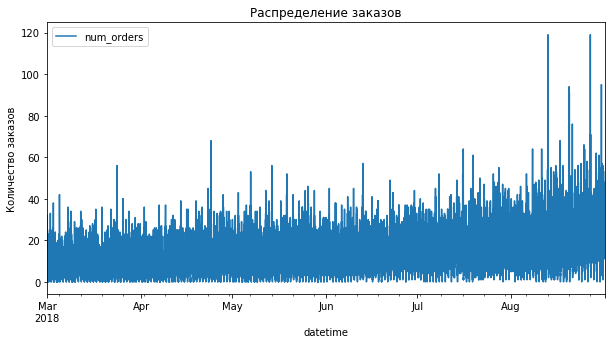

In [4]:
data.plot(figsize=(10, 5))
plt.title("Распределение заказов")
plt.ylabel("Количество заказов")
plt.show()

В наших руках данные о заказах такси в период с 1го марта по 31 августа, пропусков нет.Интервал равен 10 минутам.

## Анализ

Изменим интервал данных на 1 час и сгруппируем значения по новому интервалу.

In [5]:
data.sort_index(inplace=True)
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


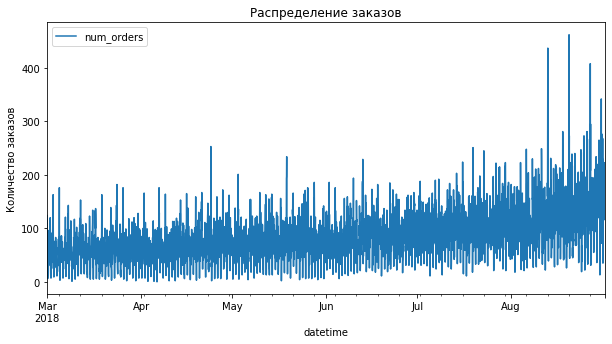

In [6]:
data.plot(figsize=(10, 5))
plt.title("Распределение заказов")
plt.ylabel("Количество заказов")
plt.show()

Разложим временной ряд на тренд и сезонную компоненту.

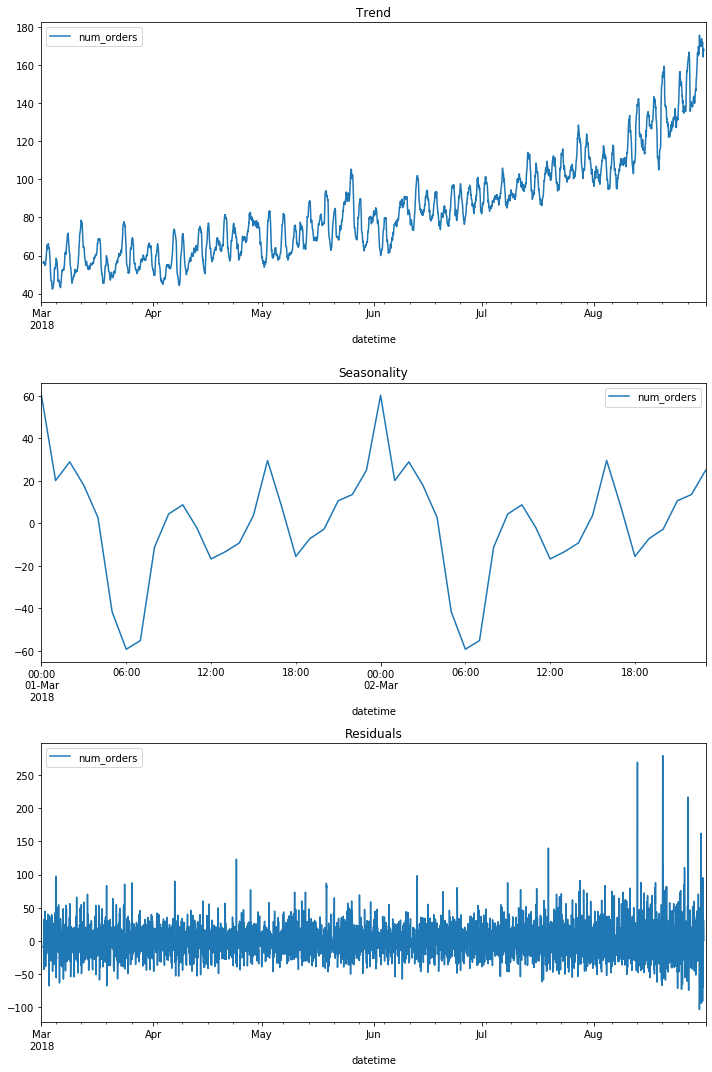

In [7]:
decomposed = seasonal_decompose(data) 
plt.figure(figsize=(10, 15))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-03-01 00:00:00':'2018-03-02 23:00:00'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Тренд на постепенное увеличение заказов в течение полугода. Суточная сезонность - количество заказов растет начиная с 7-8 часов утра и достигает пикак к полуночи. Наименьшее кол-во заказов в районе 6 утра.

Найдём скользящее стандартное отклонение для определения стационарности временного ряда.

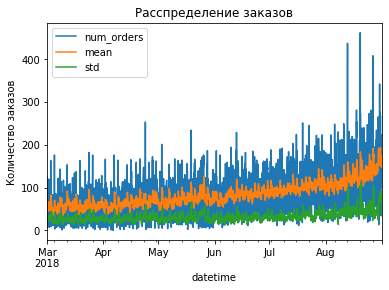

In [8]:
data['mean'] = data['num_orders'].rolling(15).mean()
data['std'] = data['num_orders'].rolling(15).std()
data.plot()
plt.title("Расспределение заказов")
plt.ylabel("Количество заказов")
plt.show()

На первый взгляд вывод о стационарности ряда не сделать, поэтому для проверки стационарности проведем обобщенный тест Дикки-Фуллера.

In [9]:
test = adfuller(data["num_orders"])
print ('adf: ', test[0]) 
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[1]< test[4]['5%']: 
    print ('Ряд не стационарен')
else:
    print ('Ряд стационарен')

adf:  -3.0689242890279558
p-value:  0.028940051402612906
Critical values:  {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
Ряд стационарен


Критическое значение = -3.06 < -2.86 прие 5-% доверительном интервале. Следовательно, ряд можно считать стационарным.

## Обучение

Удалим не нужные столбцы 'mean' и 'std' и напишим функцию создающую признаки, необходимые для обучения модели. Выделим календарные признаки час и день недели.

In [10]:
data = data.drop(['mean', 'std'], axis = 1)
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Разделим данные на обучающую и тестовую выборки. Выделим признаки и целевой признак. Подберем значения для лага(max_lag) и скользящего среднего(rolling_mean_size) на основании результата на обучающей выборке выборке.

In [11]:
def selection_parameters(mod):
    best_rmse = 1000
    values = [i for i in range(1, 30, 3)]
    for max_lag in values:
        for rolling_mean_size in values:
            data_change = make_features(data, max_lag, rolling_mean_size) 
        
            train, test = train_test_split(data, shuffle=False, test_size=0.1)
            train.dropna(inplace=True)
        
            X_train = train.drop(['num_orders'], axis=1)
            y_train = train["num_orders"]

            X_test = test.drop(['num_orders'], axis=1)
            y_test = test["num_orders"]
        
            
            
            mod.fit(X_train, y_train)

            preds = mod.predict(X_train)
        
            current_rmse = (mean_squared_error(preds, y_train))**0.5
            if current_rmse < best_rmse:
                best_rmse = current_rmse
                best_max_lag = max_lag
                best_rolling_mean_size = rolling_mean_size
    print("RMSE:", best_rmse, "\nmax_lag:", best_max_lag, "\nbest_rolling_mean_size:",
          best_rolling_mean_size)
    make_features(data, best_max_lag,  best_rolling_mean_size)
    train, test = train_test_split(data, shuffle=False, test_size=0.1)
    train = train.dropna()
    target_train = train['num_orders']
    features_train = train.drop(['num_orders'], axis=1)
    target_test = test['num_orders']
    features_test = test.drop(['num_orders'], axis=1)
    return target_train, features_train, target_test, features_test

Обучим модель RandomForestRegressor

In [12]:
%%time
target_train_rf, features_train_rf, target_test_rf, features_test_rf=selection_parameters(RandomForestRegressor())

RMSE: 9.851610216311864 
max_lag: 25 
best_rolling_mean_size: 19
CPU times: user 35.2 s, sys: 84 ms, total: 35.2 s
Wall time: 35.3 s


In [13]:
%%time
params_cat = {'max_depth': range(2, 6),
             'n_estimators': range (5, 25, 5)} 
model_RF = RandomForestRegressor()
grid_RF = GridSearchCV(model_RF, params_cat, cv=5)
grid_RF.fit(features_train_rf, target_train_rf)

CPU times: user 13.3 s, sys: 17.6 ms, total: 13.3 s
Wall time: 13.4 s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': range(2, 6),
     

Модель LinearRegression

In [14]:
%%time
target_train_lr, features_train_lr, target_test_lr, features_test_lr = selection_parameters(LinearRegression())

RMSE: 25.575580070570293 
max_lag: 1 
best_rolling_mean_size: 22
CPU times: user 9.48 s, sys: 13.8 s, total: 23.3 s
Wall time: 23.2 s


In [15]:
%%time
model_lr = LinearRegression(normalize=True)
model_lr.fit(features_train_lr, target_train_lr)
pred_train = model_lr.predict(features_train_lr)

CPU times: user 32.4 ms, sys: 44.4 ms, total: 76.8 ms
Wall time: 24 ms


Модель CatBoostRegressor

In [16]:
%%time
target_train_cb, features_train_cb, target_test_cb, features_test_cb = selection_parameters(CatBoostRegressor(verbose=False))

RMSE: 13.598986728725617 
max_lag: 1 
best_rolling_mean_size: 1
CPU times: user 48min 4s, sys: 6min 21s, total: 54min 26s
Wall time: 55min 46s


In [17]:
%%time
params_cat = {'n_estimators': range (50, 200, 50),
             'max_depth': range (5, 15, 5)} 
model_CatBoost = CatBoostRegressor(verbose=False)
grid_CB = GridSearchCV(model_CatBoost, params_cat, cv=5)
grid_CB.fit(features_train_cb, target_train_cb)

CPU times: user 4min 34s, sys: 17.1 s, total: 4min 51s
Wall time: 5min 12s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostRegressor object at 0x7f4872b4fc50>,
             iid='warn', n_jobs=None,
             param_grid={'max_depth': range(5, 15, 5),
                         'n_estimators': range(50, 200, 50)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

## Тестирование

Для проверки моделей на адекватность спрогнозируем временной ряд одним и тем же числом (константой) и предыдущим значением ряда.

In [18]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

target_train = train['num_orders']
features_train = train.drop(['num_orders'], axis=1)
target_test = test['num_orders']
features_test = test.drop(['num_orders'], axis=1)

In [19]:
pred_median = np.ones(test.shape) * train['num_orders'].median()
print("RMSE медианой: ", ((mean_squared_error(test, pred_median))**0.5))
pred_previous = test.shift(fill_value=train.iloc[-1]['num_orders'])
print("RMSE предыдущим значением ряда: ", ((mean_squared_error(test, pred_previous))**0.5))

RMSE медианой:  85.81884661535099
RMSE предыдущим значением ряда:  57.53423140014499


In [20]:
%%time
pred_test_lr = model_lr.predict(features_test_lr)
print("RMSE тестовой выборки: ", ((mean_squared_error(target_test_lr, pred_test_lr))**0.5))

RMSE тестовой выборки:  45.17820798714407
CPU times: user 15.7 ms, sys: 19.4 ms, total: 35.1 ms
Wall time: 9.07 ms


In [21]:
%%time
predicted_test_RF = grid_RF.predict(features_test_rf)
print("RMSE тестовой выборки: ", ((mean_squared_error(target_test_rf, predicted_test_RF))**0.5))

RMSE тестовой выборки:  49.457696824248316
CPU times: user 14.7 ms, sys: 7.45 ms, total: 22.1 ms
Wall time: 4.42 ms


In [22]:
%%time
predicted_test_grid_CB = grid_CB.predict(features_test_cb)
print("RMSE тестовой выборки: ", ((mean_squared_error(target_test_cb, predicted_test_grid_CB))**0.5))

RMSE тестовой выборки:  52.124056458541915
CPU times: user 15.7 ms, sys: 8.09 ms, total: 23.8 ms
Wall time: 91.8 ms


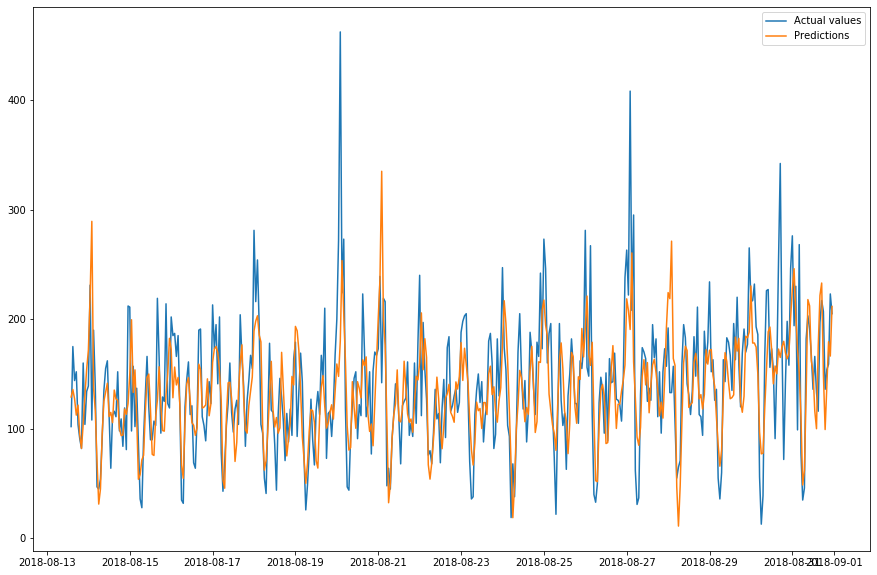

In [23]:
plt.figure(figsize=(15, 10))
plt.plot(features_test.index, target_test, label='Actual values')
plt.plot(features_test.index, pred_test_lr, label='Predictions')
plt.legend()
plt.show()

In [26]:
time = [["5min 12s", "91.8 ms", 52.12],
        ["13.4 s", "4.42 ms", 49.45],
        ["24 ms", "9.07 ms", 45.17]]
model = ["Catboost", "RandomForest", "LinearRegression"]

In [27]:
pd.DataFrame(data=time, index=model, columns=["fit_time", "predict_time", "RMSE"])

,fit_time,predict_time,RMSE
Catboost,5min 12s,91.8 ms,52.12
RandomForest,13.4 s,4.42 ms,49.45
LinearRegression,24 ms,9.07 ms,45.17


## Вывод

- на входе исследования мы имели данные о заказах такси в аэропортах от компании «Чётенькое такси». 
- целью исследования было прогнозирование количества заказов такси на следующий час. 
- метрикой нашей работы является RMSE, значение которой на тестовой выборке должно быть не больше 48.
- в процессе анализа данных было определено, что мы работаем с данными  в период с 1го марта по 31 августа с интервалом 10 минут, далее интервал был изменен на 1 час, в соответствии с условием задачи. Так же была проведена проверка временного ряда на стационарнсть.
- для решения задачи были использованы модели "Catboost", "RandomForest", "LinearRegression" с подбором гиперпараметров, и было определено, что наилучший показатель метрики RMSE дает модель LinearRegression. RMSE линейной регрессии = 45.24, что удовлетворяет условию задачи. Модель также проходит проверку на адекватность сравнением с константной моделью и моделью построеной предыдущим значением ряда.